# Probabilistic Models

In [56]:
import os
import re
import pickle
import time
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IndexerCACM import *
from RelevantParser import *
from Query import *
from IRmodel import *
from Vector import *
from IRList import *
from EvalMeasure import *
from EvalIRModel import *
from copy import *
from ggplot import *

### Get Indexers

In [16]:
# Processed collections 
collectionPath = 'data/cacm/cacm.txt'
collectionPath2 = 'data/cisi/cisi.txt'
queriesPath = 'data/cacm/cacm.qry'
relevantPath = 'data/cacm/cacm.rel'

In [17]:
indexer = IndexerCACM(collectionPath, ParserCACM())

# If Index and Inv Index aren't already builded
#indexer.createRepIndex()
#indexer.createRepInvIndex()
#indexer.createRepInvFromAll()

queriesIndexer = IndexerCACM(queriesPath, ParserCACM())

# If Index isn't already builded
#queriesIndexer.createRepIndex()

relevantIndexer = Indexer(relevantPath, RelevantParser())

# If Index and Inv Index aren't already builded
#relevantIndexer.createIndex()

In [18]:
q = query(1, queriesIndexer, relevantIndexer)
q2 = query(2, queriesIndexer, relevantIndexer)
q4 = query(4, queriesIndexer, relevantIndexer)
print(q.text, q.el)

(' \n  \n  \n   What articles exist which deal with TSS (Time Sharing System), an operating system for IBM computers?', {'comput': 1.0, 'ibm': 1.0, 'deal': 1.0, 'share': 1.0, 'articl': 1.0, 'exist': 1.0, 'operat': 1.0, 'time': 1.0, 'tss': 1.0, -1: 9.0})


## Language Model

$P_M(s) = \prod_{i=1}^n p_M(s_i)$

where $P_M(s)$ probability to observe sequence of words $s$ with language model $M$.

We want to use this measure to compare documents with a query so we can be satisfied with something proportional to this (so we can use $\log$).

It leads to this measure :

$f(q,d) = \log P_{M_d}(q) = \sum_{t\in q} tf(t,q)\log p_{M_d}(t)$

where $q$ is a query, $d$ a document, $t$ a term.

And we have $p_{M_d}(t)$ equal to $\frac{tf(t,d)}{L(d)}$

** Sometimes t from q isn't in d ** it leads to,

$\log p_M(t) = -\infty $ cad $\log P_{M_d}(q) = -\infty$ even if other terms from q give a good similarity with $M_d$.

Good method to avoid that is a smoothed prob :

$\log p_M(t) = \log(\lambda p_{M_d}(t)+(1-\lambda)p_{M_c}(t)))$

where $M_C$ is the model language on the whole corpus.

In [19]:
class LanguageModel(IRmodel):
    
    def __init__(self, indexer, lbd=0.5):

        IRmodel.__init__(self, indexer)
        self.lbd = lbd
    
    def probModelDoc(self, id, element):
        
        freq = indexer.getEfFromDoc(id)
        if element in freq:
            return freq[element]/float(freq[-1])
        else:
            return 0
    
    def probModelAll(self, element):
        
        if element in indexer.repInvFromAll:
            return indexer.repInvFromAll[element] \
                /float(indexer.repInvFromAll[-1])
        else:
            return 0
            
    def getScores(self, query):
        
        query = copy(query)
        query.pop(-1)
        scores = np.zeros(self.nDoc, [('id', 'a25'), ('score', 'float64')])
        
        dic = {}
        for element in query:
            if element in self.indexer.invIndex:
                for doc in self.indexer.getDfFromEl(element):
                    dic[doc] = 1
        dic.pop(-1)
                
        last = 0
        for element in query:
            i = 0
            tf = query[element]
            if element in self.indexer.invIndex:
                docFromElement = self.indexer.getDfFromEl(element)
                probModelAll = (1 - self.lbd)*self.probModelAll(element)
                tfProbModelAll = tf * np.log(probModelAll)
                for id in dic:
                    scores[i]['id'] = id
                    if id in docFromElement:
                        scores[i]['score'] += tf * np.log(self.lbd*self.probModelDoc(id, element) \
                        + (1 - self.lbd)*self.probModelAll(element))
                    else:
                        scores[i]['score'] += tfProbModelAll
                    i += 1
                last += tfProbModelAll
                
        for doc in self.indexer.index:
            if doc not in dic:
                scores[i]['id'] = doc
                scores[i]['score'] = last
                i += 1
                
        return np.array(scores)
                

In [20]:
Lm = LanguageModel(indexer, lbd=0.5)
scores =  Lm.getRanking(q4.el)
scores[:10]

array([('3128', -200.5087374444203), ('2939', -204.81443245181094),
       ('2342', -210.30597676817862), ('2376', -211.07751003171762),
       ('1135', -211.54921494001525), ('3101', -212.44311479693985),
       ('2470', -213.18074144702769), ('2851', -213.52224696191894),
       ('616', -214.2852915463863), ('2931', -214.30189562878545)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

## Okapi BM25 Model

$f(d,q) = \sum_{t\in q}idf'(t)\frac{(k_1+1)tf(t,d)}{k_1((1-b)+bL(d)/L_{mean}+tf(t,d))}$ where,

probabilistic $idf'(t) = max(0, \log\frac{N-df(t)+0.5}{df(t)+0.5})$.

$L_{mean}$ is the mean size of documents.

$k_1 \in [1.2, 2.0]$ and $b = 0.75$ are free parameters.

In [21]:
class Okapi(IRmodel):
    
    def __init__(self, indexer, k=1.5, b=0.75):
        
        IRmodel.__init__(self, indexer)
        self.k = k
        self.b = b
        
        self.nDoc = len(indexer.indexFromCol)
        
        
        self.lMean = float(indexer.repInvFromAll[-1])/self.nDoc
    
    def idf(self, elements):
        
        result = {}
        
        for element in elements:
            if element in indexer.invIndex:
                df = len(indexer.getDfFromEl(element))-1
                result[element] = \
                max(0, np.log((self.nDoc-df+0.5) / (df+0.5)))
            else:
                result[element] = 0
        
        return result
        
    def getScores(self, query):
        
        query = copy(query)
        query.pop(-1)
        scores = np.zeros(self.nDoc, [('id', 'a25'), ('score', 'float64')])
        
        idf = self.idf(query)
        
        dic = {}
        for element in query:
            if element in self.indexer.invIndex:
                for doc in self.indexer.getDfFromEl(element):
                    dic[doc] = 1
        dic.pop(-1)
        
        for element in query:
            i = 0
            if element in self.indexer.invIndex:
                for id in dic:
                    tf = self.indexer.getEfFromDoc(id)
                    docFromElement = self.indexer.getDfFromEl(element)
                    scores[i]['id'] = id
                    if id in docFromElement:
                        scores[i]['score'] \
                        += idf[element] \
                        * ((self.k + 1) * tf[element]) \
                        / (self.k * ((1 - self.b) + self.b * tf[-1] \
                        / self.lMean) + tf[element])
                    i += 1
                
        return np.array(scores)

In [22]:
Lm = Okapi(indexer)
scores =  Lm.getRanking(q4.el)
scores[:10]

array([('3128', 39.37750548907958), ('2342', 36.10587821997375),
       ('2851', 33.732113804675556), ('1135', 33.07152173146899),
       ('2939', 32.11246545437537), ('2931', 30.633633939642397),
       ('2470', 28.46384246251964), ('2376', 27.991841791067372),
       ('1145', 25.77010242476367), ('616', 25.126548366002996)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

## Optimisation

In [11]:
models = [LanguageModel(indexer, lbd=i) for i in np.linspace(0,1,20)]
queries = np.random.permutation([query(i, queriesIndexer, relevantIndexer) for i in queriesIndexer.index if i in relevantIndexer.indexFromCol])
ratio = int(len(queries)*0.9)
queriesTrain = queries[:ratio]
queriesTest = queries[ratio:]
measures = [EvalPrecisionAverage] 

saveResults(models, queriesTrain, measures, 'LanguageTrain')
saveResults(models, queriesTest, measures, 'LanguageTest')

('Computing Model 0... ', {'nDoc': 4204, 'lbd': 0.0, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})


EvalMeasure.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  np.in1d(self.irlist.scores[:i]['id'], self.irlist.query.relevants).sum()
/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('Computing Model 1... ', {'nDoc': 4204, 'lbd': 0.052631578947368418, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 2... ', {'nDoc': 4204, 'lbd': 0.10526315789473684, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 3... ', {'nDoc': 4204, 'lbd': 0.15789473684210525, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 4... ', {'nDoc': 4204, 'lbd': 0.21052631578947367, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 5... ', {'nDoc': 4204, 'lbd': 0.26315789473684209, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 6... ', {'nDoc': 4204, 'lbd': 0.31578947368421051, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 7... ', {'nDoc': 4204, 'lbd': 0.36842105263157893, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 8... ', {'nDoc': 4204, 'lbd': 0.42105263157894735,

/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log


('Computing Model 0... ', {'nDoc': 4204, 'lbd': 0.0, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 1... ', {'nDoc': 4204, 'lbd': 0.052631578947368418, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 2... ', {'nDoc': 4204, 'lbd': 0.10526315789473684, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 3... ', {'nDoc': 4204, 'lbd': 0.15789473684210525, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 4... ', {'nDoc': 4204, 'lbd': 0.21052631578947367, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 5... ', {'nDoc': 4204, 'lbd': 0.26315789473684209, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 6... ', {'nDoc': 4204, 'lbd': 0.31578947368421051, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 7... ', {'nDoc': 4204, 'lbd': 0.36842105263157893, 'indexer': <Ind

[[ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]]
    Mean  Var  Index
0    NaN  NaN      0
1    NaN  NaN      1
2    NaN  NaN      2
3    NaN  NaN      3
4    NaN  NaN      4
5    NaN  NaN      5
6    NaN  NaN      6
7    NaN  NaN      7
8    NaN  NaN      8
9    NaN  NaN      9
10   NaN  NaN     10
11   NaN  NaN     11
12   NaN  NaN     12
13   NaN  NaN     13
14   NaN  NaN     14
15   NaN  NaN     15
16   NaN  NaN     16
17   NaN  NaN     17
18   NaN  NaN     18
19   NaN  NaN     19


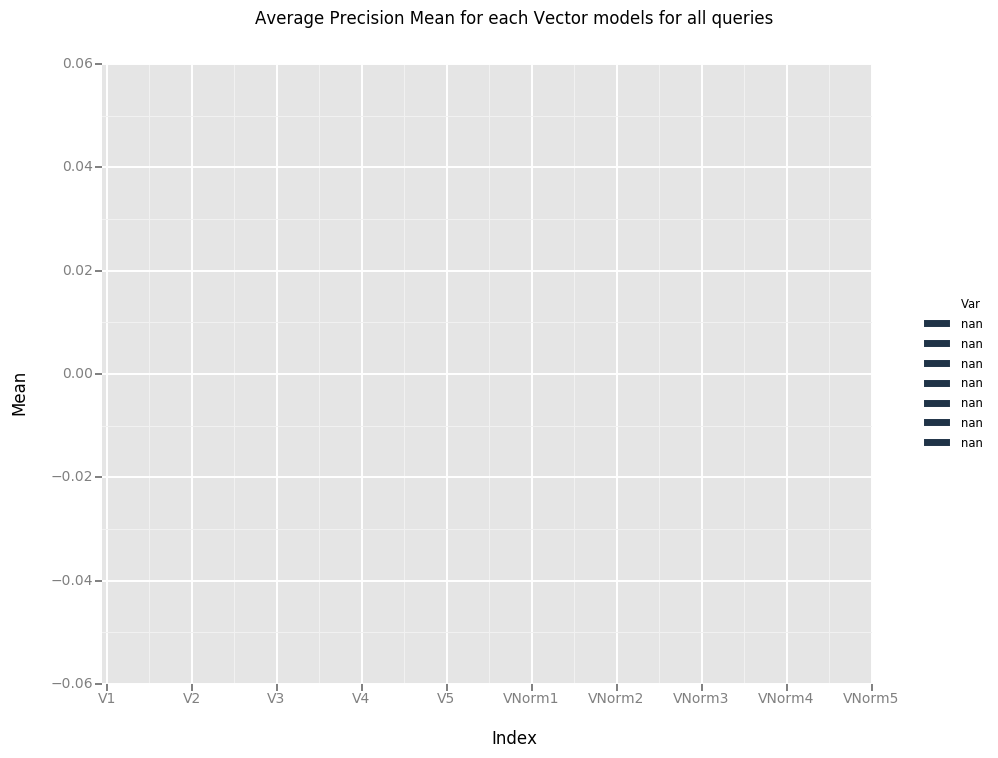

<ggplot: (8789782703433)>

In [32]:
# load resume
f = open('results/LanguageTrainResume.txt', 'r')
resume = pickle.load(f)
f.close()

print(resume)
new = pd.DataFrame(data=resume, columns=['Mean', 'Var'])
new['Index'] = np.arange(20)

print(new)
ggplot(aes(x='Index', y='Mean', color='Var'), data=new) + \
    geom_point(size=100) + \
    scale_x_continuous(breaks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], \
                      labels=['V1', 'V2', 'V3', 'V4', 'V5', 'VNorm1', 'VNorm2', 'VNorm3', 'VNorm4', 'VNorm5']) + \
    ggtitle('Average Precision Mean for each Vector models for all queries')

In [14]:
models = [Okapi(indexer, k=k, b=b) for k in np.linspace(1,4,10) for b in np.linspace(0,1,5)]

saveResults(models, queriesTrain, measures, 'OkapiTrain')
saveResults(models, queriesTest, measures, 'OkapiTest')

('Computing Model 0... ', {'nDoc': 4204, 'k': 1.0, 'b': 0.0, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 1... ', {'nDoc': 4204, 'k': 1.0, 'b': 0.25, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 2... ', {'nDoc': 4204, 'k': 1.0, 'b': 0.5, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 3... ', {'nDoc': 4204, 'k': 1.0, 'b': 0.75, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 4... ', {'nDoc': 4204, 'k': 1.0, 'b': 1.0, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 5... ', {'nDoc': 4204, 'k': 1.3333333333333333, 'b': 0.0, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe8865bd3d0>})
('Computing Model 6... ', {'nDoc': 4204, 'k': 1.3333333333333333,

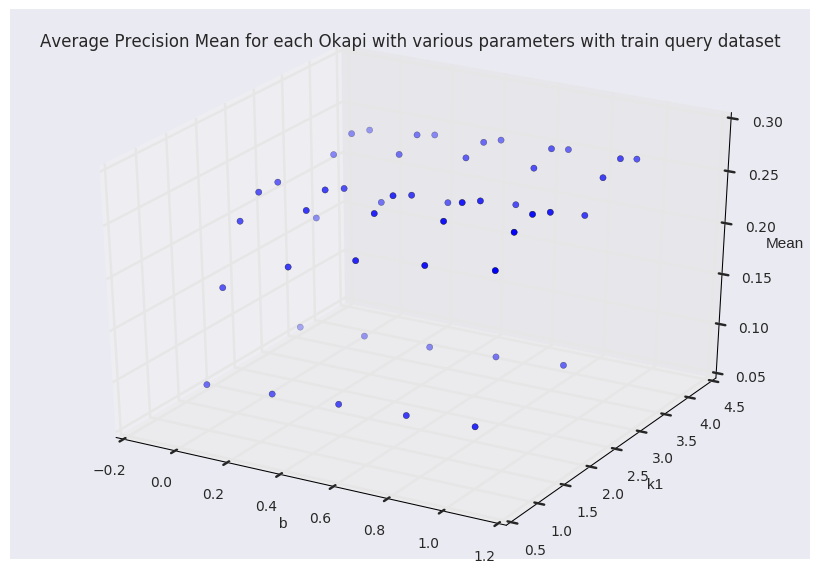

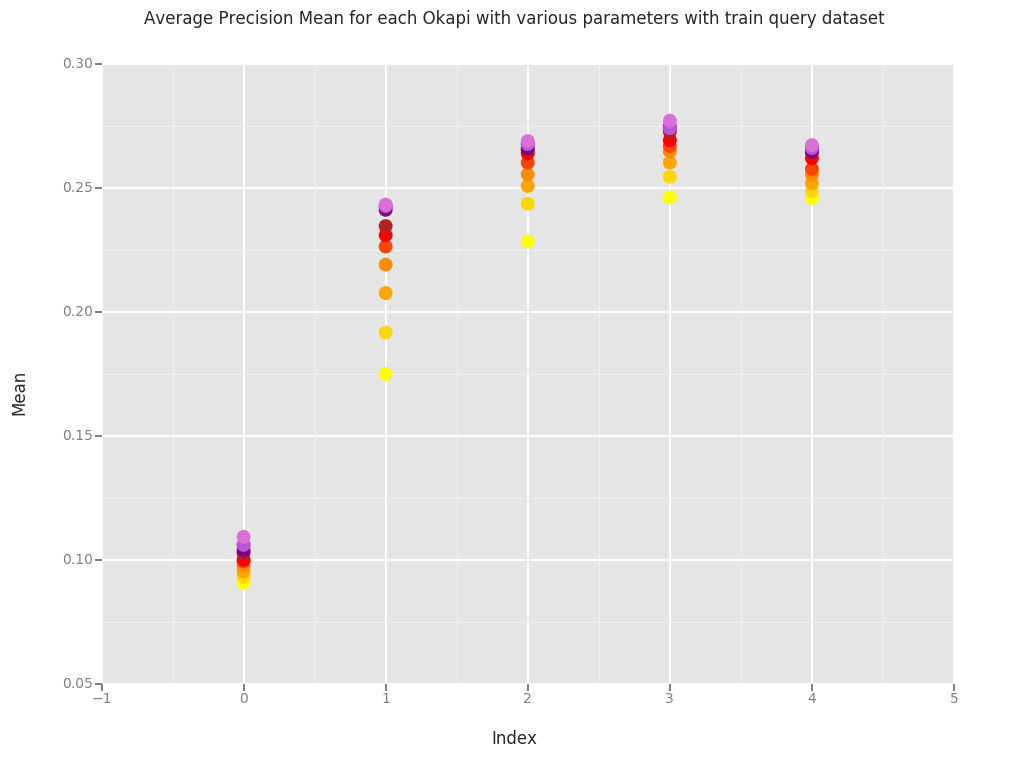

<ggplot: (8789769719533)>

In [129]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

# load resume
f = open('results/OkapiTrainResume.txt', 'r')
resume = pickle.load(f)
f.close()

fig = pylab.figure()
ax = Axes3D(fig)

x_axis = [i for i in np.linspace(0,1,5) for x in range(10)]
y_axis = np.linspace(1,4,10)
y_axis = np.concatenate((y_axis, y_axis, y_axis, y_axis, y_axis))
ax.scatter(x_axis, y_axis, resume[:,0])
ax.set_xlabel('b')
ax.set_ylabel('k1')
ax.set_zlabel('Mean')
plt.title('Average Precision Mean for each Okapi with various parameters with train query dataset')
plt.show()

data1 = pd.DataFrame(data=resume[:5], columns=['Mean', 'Var'])
data1['Index'] = np.arange(5)
data2 = pd.DataFrame(data=resume[5:10], columns=['Mean', 'Var'])
data2['Index'] = np.arange(5)
data3 = pd.DataFrame(data=resume[10:15], columns=['Mean', 'Var'])
data3['Index'] = np.arange(5)
data4 = pd.DataFrame(data=resume[15:20], columns=['Mean', 'Var'])
data4['Index'] = np.arange(5)
data5 = pd.DataFrame(data=resume[20:25], columns=['Mean', 'Var'])
data5['Index'] = np.arange(5)
data6 = pd.DataFrame(data=resume[25:30], columns=['Mean', 'Var'])
data6['Index'] = np.arange(5)
data7 = pd.DataFrame(data=resume[30:35], columns=['Mean', 'Var'])
data7['Index'] = np.arange(5)
data8 = pd.DataFrame(data=resume[35:40], columns=['Mean', 'Var'])
data8['Index'] = np.arange(5)
data9 = pd.DataFrame(data=resume[40:45], columns=['Mean', 'Var'])
data9['Index'] = np.arange(5)
data10 = pd.DataFrame(data=resume[45:50], columns=['Mean', 'Var'])
data10['Index'] = np.arange(5)

ggplot(aes(x='Index', y='Mean'), data=data1) + \
    geom_point(size=100, color='yellow') + \
    geom_point(aes('Index', y='Mean'), color='gold', size=100, data=data2) + \
    geom_point(aes('Index', y='Mean'), color='orange', size=100, data=data3) + \
    geom_point(aes('Index', y='Mean'), color='darkorange', size=100, data=data4) + \
    geom_point(aes('Index', y='Mean'), color='orangered', size=100, data=data5) + \
    geom_point(aes('Index', y='Mean'), color='red', size=100, data=data6) + \
    geom_point(aes('Index', y='Mean'), color='firebrick', size=100, data=data7) + \
    geom_point(aes('Index', y='Mean'), color='purple', size=100, data=data8) + \
    geom_point(aes('Index', y='Mean'), color='darkorchid', size=100, data=data9) + \
    geom_point(aes('Index', y='Mean'), color='mediumorchid', size=100, data=data9) + \
    geom_point(aes('Index', y='Mean'), color='orchid', size=100, data=data10) + \
    ggtitle('Average Precision Mean for each Okapi with various parameters with train query dataset')

In [133]:
# load resume
f = open('results/OkapiTrainModels.txt', 'r')
models = pickle.load(f)
f.close()
print('Best Okapi model')
print(models[39])

Best Okapi model
{'nDoc': 4204, 'k': 3.333333333333333, 'b': 1.0, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe871733150>}


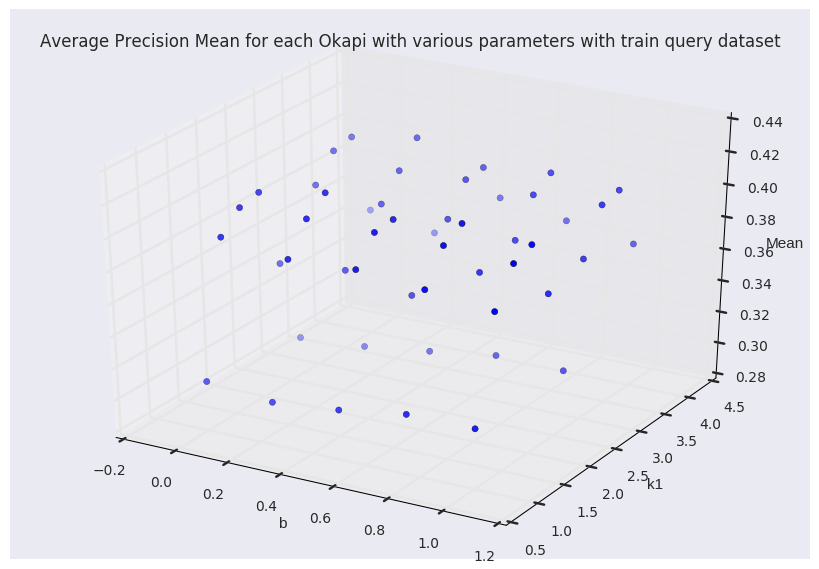

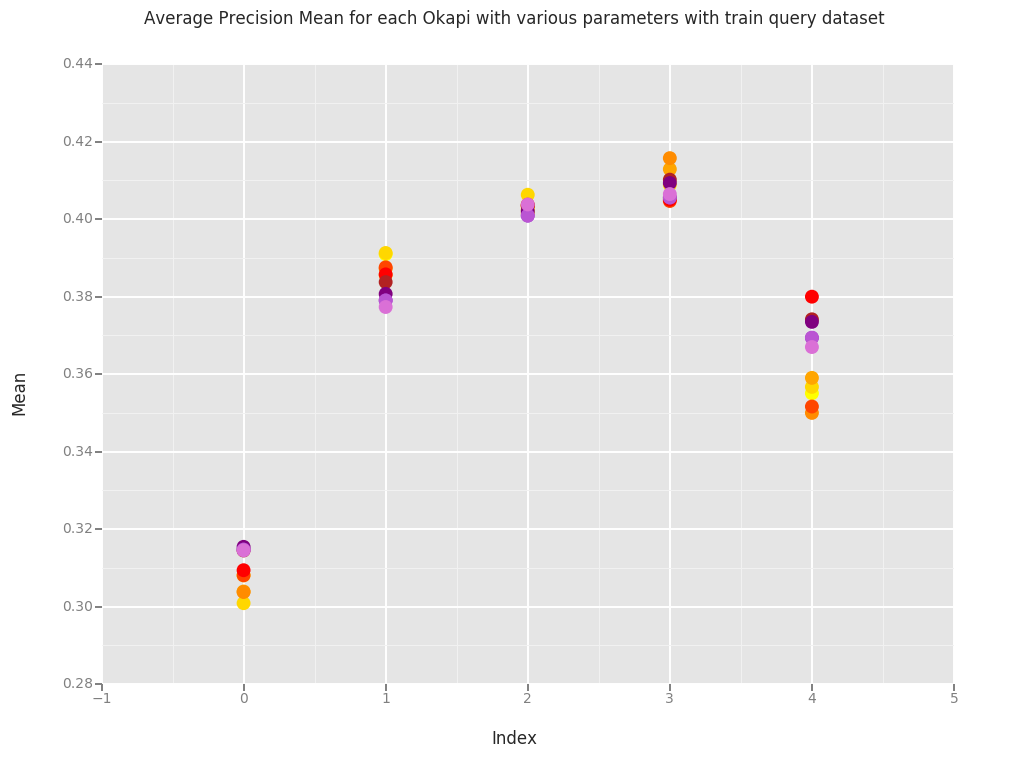

<ggplot: (8789769058897)>

In [130]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

# load resume
f = open('results/OkapiTestResume.txt', 'r')
resume = pickle.load(f)
f.close()

fig = pylab.figure()
ax = Axes3D(fig)

x_axis = [i for i in np.linspace(0,1,5) for x in range(10)]
y_axis = np.linspace(1,4,10)
y_axis = np.concatenate((y_axis, y_axis, y_axis, y_axis, y_axis))
ax.scatter(x_axis, y_axis, resume[:,0])
ax.set_xlabel('b')
ax.set_ylabel('k1')
ax.set_zlabel('Mean')
plt.title('Average Precision Mean for each Okapi with various parameters with train query dataset')
plt.show()

data1 = pd.DataFrame(data=resume[:5], columns=['Mean', 'Var'])
data1['Index'] = np.arange(5)
data2 = pd.DataFrame(data=resume[5:10], columns=['Mean', 'Var'])
data2['Index'] = np.arange(5)
data3 = pd.DataFrame(data=resume[10:15], columns=['Mean', 'Var'])
data3['Index'] = np.arange(5)
data4 = pd.DataFrame(data=resume[15:20], columns=['Mean', 'Var'])
data4['Index'] = np.arange(5)
data5 = pd.DataFrame(data=resume[20:25], columns=['Mean', 'Var'])
data5['Index'] = np.arange(5)
data6 = pd.DataFrame(data=resume[25:30], columns=['Mean', 'Var'])
data6['Index'] = np.arange(5)
data7 = pd.DataFrame(data=resume[30:35], columns=['Mean', 'Var'])
data7['Index'] = np.arange(5)
data8 = pd.DataFrame(data=resume[35:40], columns=['Mean', 'Var'])
data8['Index'] = np.arange(5)
data9 = pd.DataFrame(data=resume[40:45], columns=['Mean', 'Var'])
data9['Index'] = np.arange(5)
data10 = pd.DataFrame(data=resume[45:50], columns=['Mean', 'Var'])
data10['Index'] = np.arange(5)

ggplot(aes(x='Index', y='Mean'), data=data1) + \
    geom_point(size=100, color='yellow') + \
    geom_point(aes('Index', y='Mean'), color='gold', size=100, data=data2) + \
    geom_point(aes('Index', y='Mean'), color='orange', size=100, data=data3) + \
    geom_point(aes('Index', y='Mean'), color='darkorange', size=100, data=data4) + \
    geom_point(aes('Index', y='Mean'), color='orangered', size=100, data=data5) + \
    geom_point(aes('Index', y='Mean'), color='red', size=100, data=data6) + \
    geom_point(aes('Index', y='Mean'), color='firebrick', size=100, data=data7) + \
    geom_point(aes('Index', y='Mean'), color='purple', size=100, data=data8) + \
    geom_point(aes('Index', y='Mean'), color='darkorchid', size=100, data=data9) + \
    geom_point(aes('Index', y='Mean'), color='mediumorchid', size=100, data=data9) + \
    geom_point(aes('Index', y='Mean'), color='orchid', size=100, data=data10) + \
    ggtitle('Average Precision Mean for each Okapi with various parameters with train query dataset')

In [134]:
# load resume
f = open('results/OkapiTrainModels.txt', 'r')
models = pickle.load(f)
f.close()
print('Best Okapi model for Test')
print(models[32])

Best Okapi model for Test
{'nDoc': 4204, 'k': 3.0, 'b': 0.5, 'lMean': 567.4374405328259, 'indexer': <IndexerCACM.IndexerCACM object at 0x7fe87107d0d0>}
